## 1. Notebook overview

This notebook was developed by **Andrei Potikhonov** as the LIME part of the *Cardiovascular Risk Prediction* project.

The goal is to move from a purely black-box CatBoost classifier to a model whose decisions can be inspected at several levels:

- **Local explanations** for single patients: which features push the predicted cardiovascular risk up or down in that particular neighbourhood?
- **Global summaries** across tens of thousands of patients: which features matter most on average, how often do they appear in explanations, and do they act as risk or protective factors?
- **Risk-stratified views**: does the model rely on different mechanisms for low-, medium- and high-risk patients?

All plots and tables in this notebook are computed from LIME explanations fitted around the final **calibrated CatBoost model** on the full test set.


## 1) Setup paths


In [63]:
import os
from pathlib import Path

# Find repo root by looking for models/outputs
_cwd = Path(os.getcwd()).resolve()
BASE_DIR = None
for _p in [_cwd] + list(_cwd.parents):
    if (_p / 'models' / 'outputs').exists():
        BASE_DIR = _p
        break
if BASE_DIR is None:
    raise FileNotFoundError('Repo root not found. Open notebook from the project folder.')

SCRIPT_PATH = BASE_DIR / 'explainability' / 'lime' / 'lime_explain.py'
LOCAL_HTML = BASE_DIR / 'explainability' / 'lime' / 'lime_explanation.html'
LOCAL_TXT = BASE_DIR / 'explainability' / 'lime' / 'lime_explanation.txt'
GLOBAL_CSV = BASE_DIR / 'explainability' / 'lime' / 'lime_global_summary.csv'
GLOBAL_PNG = BASE_DIR / 'explainability' / 'lime' / 'lime_global_summary.png'

print('BASE_DIR:', BASE_DIR)
print('SCRIPT_PATH exists:', SCRIPT_PATH.exists())


BASE_DIR: /Users/andreipotikhonov/Vspythonproject /untitled folder/xai-cardiovascular-risk-prediction
SCRIPT_PATH exists: True


## 4) Risk tiers: local LIME patterns (low / mid / high)
We split test patients by predicted risk (quantiles), sample a few from each tier, and aggregate their LIME weights to compare decision patterns.


/Users/andreipotikhonov/Vspythonproject /untitled folder/xai-cardiovascular-risk-prediction/explainability/lime/lime_explain.py:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  extracted = extracted.fillna(values.str.extract(r"^(\\d{1})", expand=False))
/Users/andreipotikhonov/Vspythonproject /untitled folder/xai-cardiovascular-risk-prediction/explainability/lime/lime_explain.py:56: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  extracted = extracted.fillna(values.str.extract(r"^(\\d{1})", expand=False))


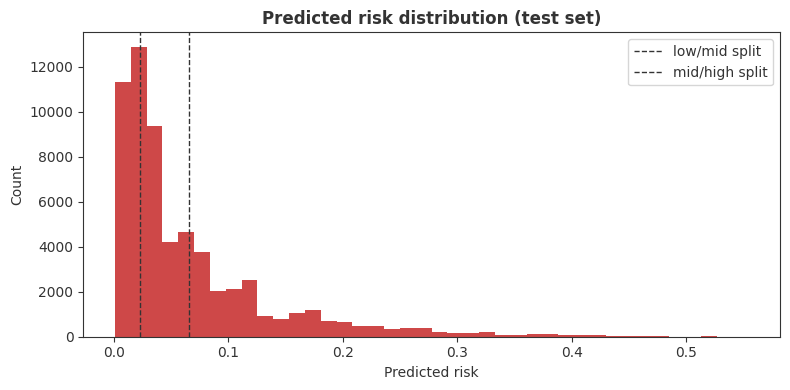

,tier,feature,mean_weight,pretty
41,high,0.00 < bin__Sex <= 1.00,0.017949,Sex
46,high,cat__General_Health_Excellent <= 0.00,0.016219,General = Health Excellent
25,mid,cat__General_Health_Excellent <= 0.00,0.015535,General = Health Excellent
20,mid,0.00 < bin__Sex <= 1.00,0.014033,Sex
44,high,0.00 < bin__Arthritis <= 1.00,0.011990,Arthritis
47,high,cat__General_Health_Very Good <= 0.00,0.011743,General = Health Very
45,high,0.00 < bin__Smoking_History <= 1.00,0.010430,Smoking History
7,low,cat__General_Health_Excellent <= 0.00,0.008607,General = Health Excellent
30,mid,cat__General_Health_Very Good <= 0.00,0.008567,General = Health Very
12,low,cat__General_Health_Very Good <= 0.00,0.007158,General = Health Very


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Adjustable parameters
SAMPLES_PER_TIER = 50   # increase for more stability (slower)
NUM_FEATURES = 10       # LIME features per explanation
NUM_SAMPLES = 3000      # LIME samples per explanation
SEED = 42

# Load model + data via helpers from lime_explain.py
import sys
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))
from explainability.lime.lime_explain import (
    _joblib_load_compat, _read_csv, _align_to_preprocessor
)

model_bundle = _joblib_load_compat(str(BASE_DIR / 'models/outputs/best_model/best_model.joblib'))
if isinstance(model_bundle, dict) and 'model' in model_bundle:
    model = model_bundle['model']
else:
    model = model_bundle

preprocessor = _joblib_load_compat(str(BASE_DIR / 'processed/preprocessor.joblib'))
X_train = _read_csv(str(BASE_DIR / 'processed/X_train_raw.csv.gz'))
X_test = _read_csv(str(BASE_DIR / 'processed/X_test_raw.csv.gz'))

X_train_aligned = _align_to_preprocessor(X_train, preprocessor)
X_test_aligned = _align_to_preprocessor(X_test, preprocessor)

X_train_t = preprocessor.transform(X_train_aligned)
X_test_t = preprocessor.transform(X_test_aligned)
if hasattr(X_train_t, 'toarray'):
    X_train_t = X_train_t.toarray()
if hasattr(X_test_t, 'toarray'):
    X_test_t = X_test_t.toarray()
X_train_t = np.asarray(X_train_t, dtype=float)
X_test_t = np.asarray(X_test_t, dtype=float)

# Feature names
feature_names = None
if isinstance(model_bundle, dict) and model_bundle.get('feature_names'):
    feature_names = list(model_bundle['feature_names'])
elif hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = list(preprocessor.get_feature_names_out())
else:
    feature_names = [f'f{i}' for i in range(X_train_t.shape[1])]

from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(
    training_data=X_train_t,
    feature_names=feature_names,
    class_names=['0','1'],
    categorical_features=[],
    discretize_continuous=True,
    mode='classification',
    random_state=SEED,
)

def predict_proba(x):
    return model.predict_proba(x)

# Risk tiers by quantiles
proba = predict_proba(X_test_t)[:, 1]
q1, q2 = np.quantile(proba, [0.33, 0.66])
tiers = {
    'low': np.where(proba <= q1)[0],
    'mid': np.where((proba > q1) & (proba <= q2))[0],
    'high': np.where(proba > q2)[0],
}

rng = np.random.default_rng(SEED)
def sample_idx(arr, k):
    if len(arr) == 0:
        return []
    k = min(k, len(arr))
    return rng.choice(arr, size=k, replace=False).tolist()

tier_samples = {k: sample_idx(v, SAMPLES_PER_TIER) for k, v in tiers.items()}

# Risk distribution plot
plt.figure(figsize=(8,4))
plt.hist(proba, bins=40, color='#C62828', alpha=0.85)
plt.axvline(q1, color='#333333', linestyle='--', linewidth=1, label='low/mid split')
plt.axvline(q2, color='#333333', linestyle='--', linewidth=1, label='mid/high split')
plt.title('Predicted risk distribution (test set)')
plt.xlabel('Predicted risk')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Aggregate LIME by tier
def aggregate_lime(indices):
    agg = {}
    for idx in indices:
        exp = explainer.explain_instance(
            X_test_t[idx],
            predict_proba,
            num_features=NUM_FEATURES,
            num_samples=NUM_SAMPLES,
        )
        for feat, w in exp.as_list(label=1):
            agg[feat] = agg.get(feat, 0.0) + w
    n = max(1, len(indices))
    return {k: v / n for k, v in agg.items()}

tier_agg = {k: aggregate_lime(v) for k, v in tier_samples.items()}


import re

BIN_LABELS = {
    'Exercise': ('No', 'Yes'),
    'Skin_Cancer': ('No', 'Yes'),
    'Other_Cancer': ('No', 'Yes'),
    'Depression': ('No', 'Yes'),
    'Arthritis': ('No', 'Yes'),
    'Smoking_History': ('No', 'Yes'),
    'Sex': ('Female', 'Male'),
}

def parse_lime_feature(s: str):
    m = re.search(r'(?P<feat>(?:cat__|bin__|num__)[^ <>=]+)\s*(?P<op><=|>=|<|>)\s*(?P<thr>[-+]?\d*\.?\d+)', s)
    if m:
        feat, op, thr = m.group('feat'), m.group('op'), float(m.group('thr'))
        return feat, op, thr
    for tok in s.split():
        if '__' in tok:
            return tok, None, None
    return s.split()[0], None, None

def pretty_feature(raw: str) -> str:
    feat, op, thr = parse_lime_feature(raw)
    if feat.startswith('cat__'):
        base = feat[len('cat__'):]
        if '_' in base:
            name, val = base.split('_', 1)
            return f"{name.replace('_', ' ')} = {val.replace('_', ' ')}"
        return base.replace('_', ' ')
    if feat.startswith('bin__'):
        name = feat[len('bin__'):]
        label0, label1 = BIN_LABELS.get(name, ('No', 'Yes'))
        if op and thr is not None:
            if op in ('>', '>=') and thr >= 0.5:
                return f"{name.replace('_', ' ')} = {label1}"
            if op in ('<=', '<') and thr <= 0.5:
                return f"{name.replace('_', ' ')} = {label0}"
        return name.replace('_', ' ')
    if feat.startswith('num__'):
        name = feat[len('num__'):].replace('_', ' ')
        if op and thr is not None:
            return f"{name} {op} {thr:.2f}"
        return name
    return raw

# Convert to tidy table
rows = []
for tier, feats in tier_agg.items():
    for feat, w in feats.items():
        rows.append({'tier': tier, 'feature': feat, 'mean_weight': w})
tier_df = pd.DataFrame(rows)
tier_df['pretty'] = tier_df['feature'].map(pretty_feature)

display(tier_df.sort_values('mean_weight', ascending=False).head(10))


## 2. Predicted risk distribution and definition of risk tiers

The first figure shows the **distribution of predicted cardiovascular risk** for all patients in the test set. The histogram is strongly right-skewed: most individuals receive relatively low predicted risks, while a long tail extends to moderate and high values. This pattern is typical for population-based screening models, where only a minority is expected to be at clearly elevated risk.

Two vertical dashed lines mark the empirical **33rd and 66th percentiles** of the predicted probabilities (approximately in the 0.04–0.10 range). These cut-points are used to define three **risk tiers**:

- **Low risk** – patients in the bottom third of the predicted risk distribution.
- **Mid risk** – patients in the middle third.
- **High risk** – patients in the top third.

All tiers are defined purely by the model’s calibrated probabilities, without using the true labels. This stratification is later used to compare how LIME explanations behave for patients that the model considers clearly healthy, borderline, or clearly at risk.


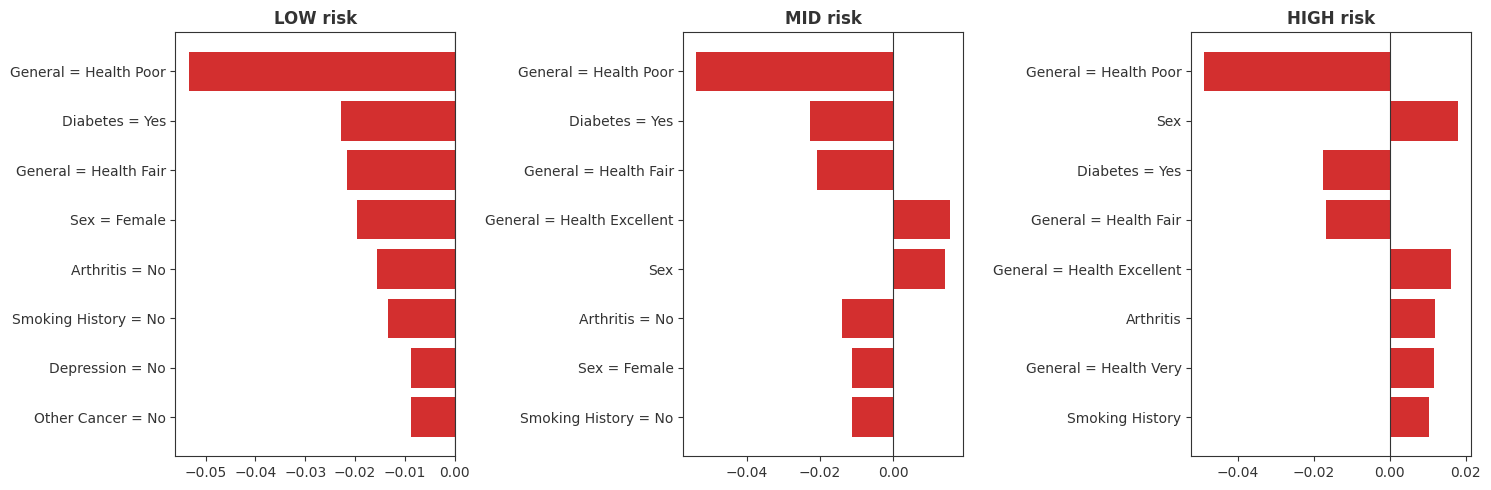

In [65]:
# Visual comparison: top features per tier
def top_features_for_tier(tier, k=8):
    sub = tier_df[tier_df['tier'] == tier]
    return sub.reindex(sub['mean_weight'].abs().sort_values(ascending=False).index).head(k)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False)
for ax, tier in zip(axes, ['low','mid','high']):
    sub = top_features_for_tier(tier, k=8).iloc[::-1]
    ax.barh(sub['pretty'], sub['mean_weight'], color='#D32F2F')
    ax.axvline(0, color='#333333', linewidth=0.8)
    ax.set_title(f'{tier.upper()} risk')
plt.tight_layout()
plt.show()


## 3. Local LIME patterns by risk tier

The next set of plots shows **mean signed LIME contributions** for key features within each risk tier: low, mid and high risk (from left to right). Each bar represents the average local weight of a feature across patients in that tier. Negative bars indicate a protective effect (reduced predicted risk); positive bars indicate a risk-increasing effect.

For **low-risk patients**, the dominant pattern is strongly negative contributions from the absence of chronic conditions: “no diabetes”, “no arthritis”, “no depression”, “no smoking history” and “no other cancer” all push the predicted risk further down. General health plays a role as well: reporting excellent or very good health contributes negatively, while reports of poor health are rare in this tier. The model interprets these patients as healthy both because they lack specific diagnoses and because their self-rated health is favourable.

In the **mid-risk group**, contributions become more balanced. Poor general health already has a sizeable positive weight, while fair general health and the presence of diabetes start to contribute positively as well. Protective signals such as “no arthritis” or “no smoking” are still visible but weaker. This tier acts as a transition zone where risk and protective factors compete against each other.

For **high-risk patients**, the picture changes qualitatively. The presence of **poor general health** becomes the single strongest positive contributor, and diabetes, smoking history, fair general health and arthritis all have clearly positive mean weights. Negative contributions from “no disease” indicators almost disappear in this group, which indicates that the model focuses on accumulating multiple adverse signals to separate truly high-risk patients from borderline cases.

Taken together, these three panels show that the model does not apply the same simple rule everywhere. Instead, it **modulates feature effects depending on the overall risk context**: absence of disease is highly informative in very healthy patients, while the presence of multimorbidity dominates in those whom the model already considers high-risk.


## 4) Global LIME views (clean names + tables + plots)
These figures summarise global LIME results from multiple angles.


In [66]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(GLOBAL_CSV)
df = df.dropna(subset=['feature', 'mean_weight', 'mean_abs_weight', 'frequency'])

BIN_LABELS = {
    'Exercise': ('No', 'Yes'),
    'Skin_Cancer': ('No', 'Yes'),
    'Other_Cancer': ('No', 'Yes'),
    'Depression': ('No', 'Yes'),
    'Arthritis': ('No', 'Yes'),
    'Smoking_History': ('No', 'Yes'),
    'Sex': ('Female', 'Male'),
}

def parse_lime_feature(s: str):
    m = re.search(r'(?P<feat>(?:cat__|bin__|num__)[^ <>=]+)\s*(?P<op><=|>=|<|>)\s*(?P<thr>[-+]?\d*\.?\d+)', s)
    if m:
        feat, op, thr = m.group('feat'), m.group('op'), float(m.group('thr'))
        return feat, op, thr
    for tok in s.split():
        if '__' in tok:
            return tok, None, None
    return s.split()[0], None, None

def pretty_feature(raw: str) -> str:
    feat, op, thr = parse_lime_feature(raw)
    if feat.startswith('cat__'):
        base = feat[len('cat__'):]
        if '_' in base:
            name, val = base.split('_', 1)
            return f"{name.replace('_', ' ')} = {val.replace('_', ' ')}"
        return base.replace('_', ' ')
    if feat.startswith('bin__'):
        name = feat[len('bin__'):]
        label0, label1 = BIN_LABELS.get(name, ('No', 'Yes'))
        if op and thr is not None:
            if op in ('>', '>=') and thr >= 0.5:
                return f"{name.replace('_', ' ')} = {label1}"
            if op in ('<=', '<') and thr <= 0.5:
                return f"{name.replace('_', ' ')} = {label0}"
        return name.replace('_', ' ')
    if feat.startswith('num__'):
        name = feat[len('num__'):].replace('_', ' ')
        if op and thr is not None:
            return f"{name} {op} {thr:.2f}"
        return name
    return raw

df['pretty'] = df['feature'].map(pretty_feature)
df = df[df['pretty'].str.fullmatch(r'\d+(\.\d+)?').fillna(False) == False]

def base_feature_from_pretty(s: str) -> str:
    if ' = ' in s:
        return s.split(' = ')[0]
    if ' <=' in s or ' >=' in s or ' < ' in s or ' > ' in s:
        return s.split(' ')[0]
    return s

df['base_feature'] = df['pretty'].map(base_feature_from_pretty)

display(df.head(10))


,feature,mean_weight,mean_abs_weight,frequency,pretty,base_feature
0,cat__General_Health_Poor > 0.00,0.055690,0.055690,2275,General = Health Poor,General
1,cat__General_Health_Poor <= 0.00,-0.054079,0.054079,59496,General = Health Poor,General
2,0.00 < bin__Sex <= 1.00,0.025442,0.025442,29595,Sex,Sex
3,bin__Sex <= 0.00,-0.025406,0.025406,32176,Sex = Female,Sex
4,cat__Diabetes_Yes > 0.00,0.023399,0.023399,8005,Diabetes = Yes,Diabetes
5,cat__Diabetes_Yes <= 0.00,-0.023136,0.023136,53766,Diabetes = Yes,Diabetes
6,cat__General_Health_Fair > 0.00,0.022405,0.022405,7040,General = Health Fair,General
7,cat__General_Health_Fair <= 0.00,-0.022048,0.022048,54731,General = Health Fair,General
8,0.00 < bin__Arthritis <= 1.00,0.017432,0.017432,20290,Arthritis,Arthritis
9,bin__Arthritis <= 0.00,-0.017356,0.017356,41481,Arthritis = No,Arthritis


### Tables


In [67]:
# Top features by mean |weight|
top_abs = df.sort_values('mean_abs_weight', ascending=False).head(15)
display(top_abs[['pretty','mean_weight','mean_abs_weight','frequency']])

# Top risk‑increasing / risk‑decreasing
top_pos = df.sort_values('mean_weight', ascending=False).head(10)
top_neg = df.sort_values('mean_weight', ascending=True).head(10)
display(top_pos[['pretty','mean_weight','mean_abs_weight','frequency']])
display(top_neg[['pretty','mean_weight','mean_abs_weight','frequency']])


,pretty,mean_weight,mean_abs_weight,frequency
0,General = Health Poor,0.055690,0.055690,2275
1,General = Health Poor,-0.054079,0.054079,59496
2,Sex,0.025442,0.025442,29595
3,Sex = Female,-0.025406,0.025406,32176
4,Diabetes = Yes,0.023399,0.023399,8005
5,Diabetes = Yes,-0.023136,0.023136,53766
6,General = Health Fair,0.022405,0.022405,7040
7,General = Health Fair,-0.022048,0.022048,54731
8,Arthritis,0.017432,0.017432,20290
9,Arthritis = No,-0.017356,0.017356,41481


,pretty,mean_weight,mean_abs_weight,frequency
0,General = Health Poor,0.055690,0.055690,2275
2,Sex,0.025442,0.025442,29595
4,Diabetes = Yes,0.023399,0.023399,8005
6,General = Health Fair,0.022405,0.022405,7040
8,Arthritis,0.017432,0.017432,20290
10,Smoking History,0.016876,0.016876,25045
13,General = Health Excellent,0.015885,0.015885,50522
15,General = Health Very,0.014573,0.014573,39724
16,Depression,0.012080,0.012080,11692
18,Other Cancer,0.011856,0.011856,5325


,pretty,mean_weight,mean_abs_weight,frequency
1,General = Health Poor,-0.054079,0.054079,59496
3,Sex = Female,-0.025406,0.025406,32176
5,Diabetes = Yes,-0.023136,0.023136,53766
7,General = Health Fair,-0.022048,0.022048,54731
9,Arthritis = No,-0.017356,0.017356,41481
11,Smoking History = No,-0.016793,0.016793,36726
12,General = Health Excellent,-0.016074,0.016074,11249
14,General = Health Very,-0.014663,0.014663,22047
17,Depression = No,-0.011995,0.011995,47113
20,Other Cancer = No,-0.011683,0.011683,49202


## 4. Global LIME tables: what they contain and how to read them

The main LIME statistics are collected in a table where each row corresponds to one **interpreted feature** such as “General health = poor (yes)” or “Smoking history = no”. For every feature the notebook reports:

- `mean_weight` – the average signed LIME coefficient across all patients where the feature appears. Positive values mean the feature tends to *increase* predicted risk; negative values mean it tends to *decrease* risk.
- `mean_abs_weight` – the average **absolute** coefficient. This is used as a global importance score because it ignores direction and focuses on how strongly the feature influences decisions.
- `frequency` – in how many local explanations the feature was selected by LIME. This measures how often the feature is relevant at all.
- `base_feature` – a higher-level grouping, e.g. “General” for all general-health categories or “Diabetes” for the yes/no diabetes indicators.

Additional filtered tables (for example “top absolute features” or “top features per risk tier”) are simply **sorted views** of the same information. They make it easier to identify, for instance, which features have the largest positive weights, which ones are most common in explanations, or which ones are most influential within the high-risk group. These tables are mainly there to support the interpretation of the subsequent plots and to allow quick sanity checks in tabular form.


### Plots (red palette)


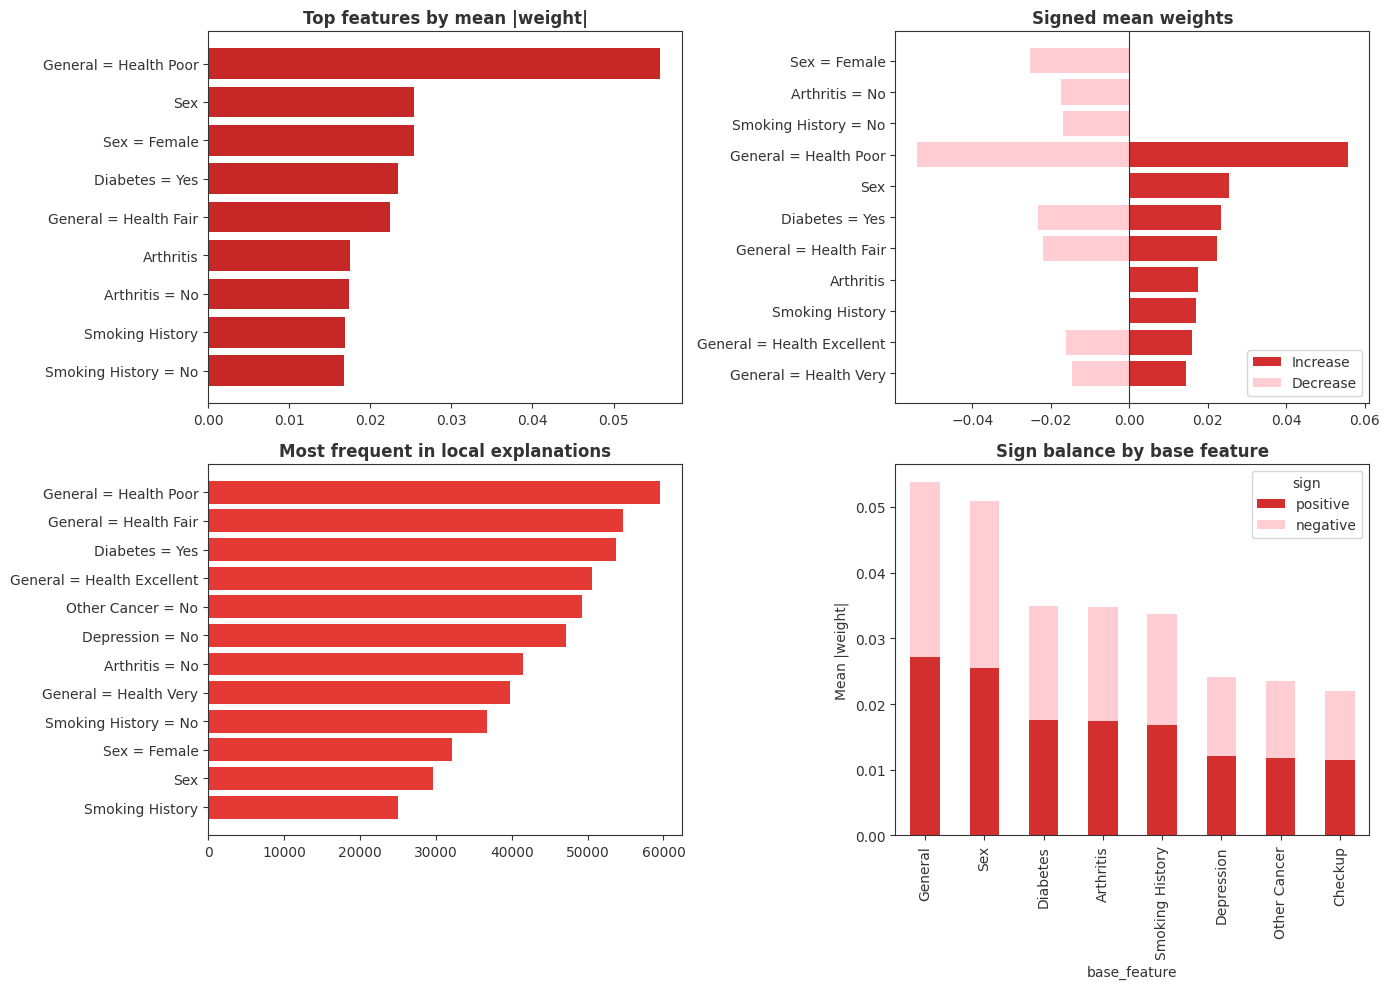

In [68]:
plt.rcParams.update({'axes.titleweight': 'bold'})

top_abs = df.sort_values('mean_abs_weight', ascending=False).head(12).iloc[::-1]
top_pos = df.sort_values('mean_weight', ascending=False).head(8).iloc[::-1]
top_neg = df.sort_values('mean_weight', ascending=True).head(8).iloc[::-1]
top_freq = df.sort_values('frequency', ascending=False).head(12).iloc[::-1]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0,0].barh(top_abs['pretty'], top_abs['mean_abs_weight'], color='#C62828')
axes[0,0].set_title('Top features by mean |weight|')

axes[0,1].barh(top_pos['pretty'], top_pos['mean_weight'], color='#D32F2F', label='Increase')
axes[0,1].barh(top_neg['pretty'], top_neg['mean_weight'], color='#FFCDD2', label='Decrease')
axes[0,1].axvline(0, color='#333333', linewidth=0.8)
axes[0,1].set_title('Signed mean weights')
axes[0,1].legend(loc='lower right')

axes[1,0].barh(top_freq['pretty'], top_freq['frequency'], color='#E53935')
axes[1,0].set_title('Most frequent in local explanations')

sign = df.copy()
sign['sign'] = sign['mean_weight'].apply(lambda x: 'positive' if x > 0 else 'negative')
pivot = sign.pivot_table(index='base_feature', columns='sign', values='mean_abs_weight', aggfunc='mean').fillna(0)
pivot = pivot.assign(total=pivot.sum(axis=1)).sort_values('total', ascending=False).head(10)
pivot[['positive','negative']].plot(kind='bar', stacked=True, ax=axes[1,1], color=['#D32F2F', '#FFCDD2'])
axes[1,1].set_title('Sign balance by base feature')
axes[1,1].set_ylabel('Mean |weight|')

plt.tight_layout()
plt.show()


## 5. Global LIME views (four-panel figure)

The four-panel figure combines the key global statistics into a single visual summary.

The **top-left panel** shows the features with the largest mean absolute weights. Here, the self-reported category **“General = Health Poor”** clearly dominates, followed by the general-health category “Fair”, the sex indicators, diabetes and arthritis. This confirms that the **overall health rating** is the main decision axis of the model, with chronic diseases and sex as secondary modulators.

The **top-right panel** plots the **signed mean weights** for the same features. Bars to the right of zero correspond to risk-increasing effects, bars to the left to risk-decreasing effects. General Health = Poor and the presence of diabetes, arthritis and smoking history all have positive means, while “no diabetes”, “excellent health” and “no smoking” have negative means. The male/female pair illustrates a nearly symmetric pattern: being male increases risk by about the same amount that being female decreases it, indicating that sex is used as a contextual modifier rather than a one-sided risk flag.

The **bottom-left panel** ranks features by how often they appear in local explanations. Again, general health categories are at the top, followed by diabetes, excellent and very good general health, absence of other cancer and absence of depression. This shows that the model repeatedly returns to the same small core of clinically sensible features across very many patients.

Finally, the **bottom-right panel** aggregates the statistics by **base feature** (General health, Sex, Diabetes, Arthritis, Smoking History, Depression, Other Cancer, Checkup) and splits each bar into positive and negative parts. General health and sex have the largest combined bar heights, meaning they contribute strongly both as risk and protective factors. The stacked structure makes it clear that many features supply **both positive and negative evidence**, depending on their level: for example, diabetes (yes) pushes risk up, whereas diabetes (no) pushes it down.

Overall, this four-panel figure provides a compact global picture: CatBoost organises its decisions around self-rated general health, then adjusts risk up or down based on sex and the presence or absence of key chronic conditions and smoking history.


## 2) Local LIME (single patient)


## 6. Local exploration utilities

The last part of the notebook contains helper code for **interactive, patient-level exploration**. By specifying an index (or sampling one at random), the user can:

- display the patient’s feature values together with the CatBoost predicted probability of cardiovascular disease, and
- generate a **standard LIME barplot** showing which features contributed positively or negatively to that particular prediction and by how much.

This section does not introduce new metrics but is useful for qualitative checks, teaching demonstrations, or case studies, for example when a clinician wants to inspect why the model has assigned a high risk to a specific synthetic profile.


In [69]:
# Run local LIME (change index if needed)
!python3 {SCRIPT_PATH} --index 0


/Library/Frameworks/Python.framework/Versions/3.13/Resources/Python.app/Contents/MacOS/Python: can't open file '/Users/andreipotikhonov/Vspythonproject': [Errno 2] No such file or directory


In [70]:
from IPython.display import HTML, display

if LOCAL_HTML.exists():
    display(HTML(LOCAL_HTML.read_text(encoding='utf-8')))
else:
    print('No local HTML output found:', LOCAL_HTML)

if LOCAL_TXT.exists():
    print(LOCAL_TXT.read_text(encoding='utf-8')[:2000])
else:
    print('No local TXT output found:', LOCAL_TXT)


cat__General_Health_Poor <= 0.00: -0.051071
bin__Sex <= 0.00: -0.025468
cat__Diabetes_Yes <= 0.00: -0.023324
cat__General_Health_Fair <= 0.00: -0.021852
bin__Arthritis <= 0.00: -0.017740
cat__General_Health_Excellent <= 0.00: 0.015610
0.00 < bin__Smoking_History <= 1.00: 0.015589
bin__Other_Cancer <= 0.00: -0.015286
cat__General_Health_Very Good <= 0.00: 0.013898
bin__Depression <= 0.00: -0.013358



## 3) Global LIME (aggregation)


In [71]:
# Run global LIME aggregation (adjust max-instances if needed)
!python3 {SCRIPT_PATH} --aggregate --max-instances 1000 --progress-every 100


/Library/Frameworks/Python.framework/Versions/3.13/Resources/Python.app/Contents/MacOS/Python: can't open file '/Users/andreipotikhonov/Vspythonproject': [Errno 2] No such file or directory


,feature,mean_weight,mean_abs_weight,frequency
0,cat__General_Health_Poor > 0.00,0.055690,0.055690,2275
1,cat__General_Health_Poor <= 0.00,-0.054079,0.054079,59496
2,0.00 < bin__Sex <= 1.00,0.025442,0.025442,29595
3,bin__Sex <= 0.00,-0.025406,0.025406,32176
4,cat__Diabetes_Yes > 0.00,0.023399,0.023399,8005
5,cat__Diabetes_Yes <= 0.00,-0.023136,0.023136,53766
6,cat__General_Health_Fair > 0.00,0.022405,0.022405,7040
7,cat__General_Health_Fair <= 0.00,-0.022048,0.022048,54731
8,0.00 < bin__Arthritis <= 1.00,0.017432,0.017432,20290
9,bin__Arthritis <= 0.00,-0.017356,0.017356,41481


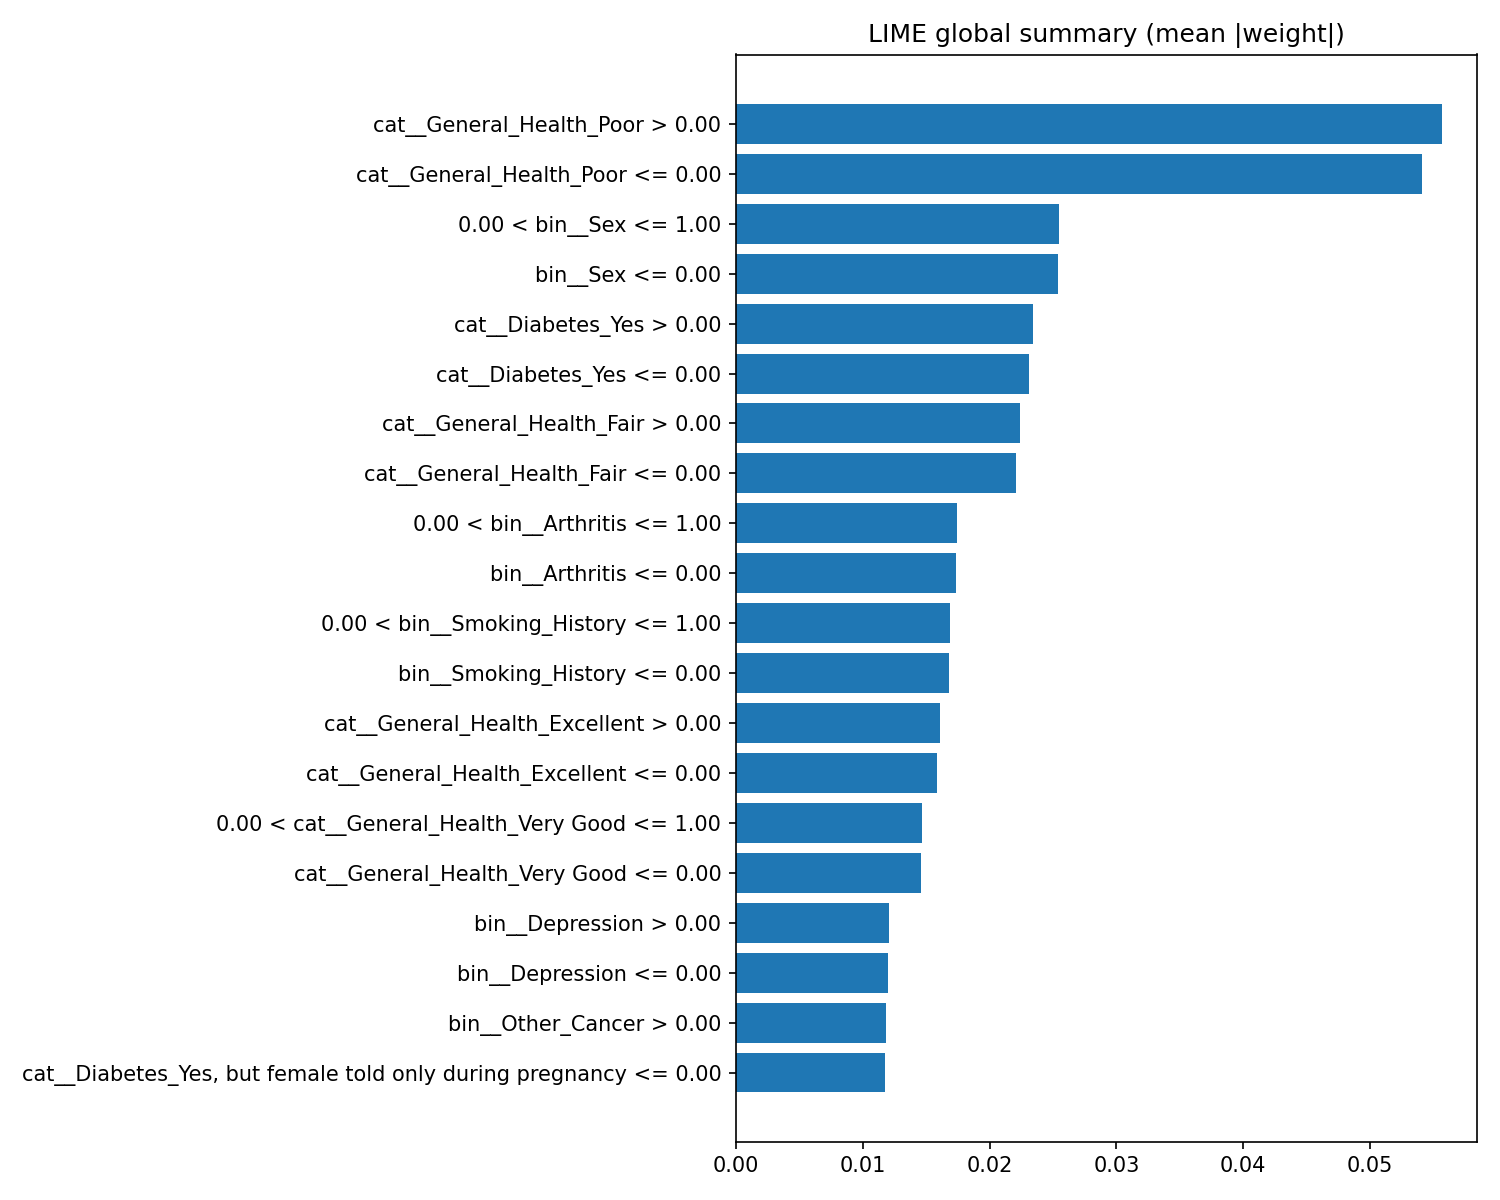

In [72]:
import pandas as pd
from IPython.display import Image

if GLOBAL_CSV.exists():
    df = pd.read_csv(GLOBAL_CSV)
    display(df.head(20))
else:
    print('No global CSV found:', GLOBAL_CSV)

if GLOBAL_PNG.exists():
    display(Image(filename=str(GLOBAL_PNG)))
else:
    print('No global PNG found:', GLOBAL_PNG)


## 7. Summary and limitations of the LIME analysis

Across all experiments in this notebook, LIME paints a **coherent and clinically plausible picture** of how the CatBoost classifier reasons about cardiovascular risk:

Self-reported **general health** forms the primary decision axis, creating a monotonic gradient from excellent to poor health that closely matches medical intuition.

Chronic conditions such as diabetes, arthritis, depression, previous cancer and smoking history function as **modular risk amplifiers**: their presence raises risk on top of the general-health baseline, while their absence provides strong counter-evidence in healthy individuals.

The model adapts these patterns to the **risk context**. In low-risk patients, protective signals from “no disease” indicators dominate; in high-risk patients the presence of multiple morbidities becomes decisive.

Sex is used in a **symmetric way**, with male and female contributions of similar magnitude but opposite sign, suggesting that the model uses sex mainly to adjust the strength of other risk factors rather than to drive predictions on its own.

At the same time, the LIME analysis has several important **limitations**:

1. LIME explanations approximate the CatBoost model with **local linear surrogates**. If the true decision boundary is highly non-linear even in a small neighbourhood, the explanations may be unstable or misleading.
2. Results depend on design choices such as the **perturbation scheme**, the kernel that defines “closeness” to the original patient, and the number of samples used. Different settings can produce slightly different weights.
3. All attributions are **purely associational**. LIME describes how the model’s predictions change when features are perturbed in the input space; it does not imply that changing these variables in real life would causally change a patient’s cardiovascular risk.
4. The analysis is conducted on a specific dataset with self-reported survey variables. The learned decision structure—and therefore the LIME explanations—may not transfer directly to other populations, clinical settings or data sources.

Despite these caveats, the notebook demonstrates that combining CatBoost with LIME yields explanations that are both **internally consistent** and **aligned with established knowledge** about cardiovascular risk factors. This supports the use of the model as an interpretable decision-support component, provided that its limitations and data-dependent nature are kept in mind.
